# QCOM I/O Tutorial

This tutorial shows how to **load** measurement and probability data from a few common formats and (optionally) **save** them back out using QCOM's I/O helpers:

- `qcom.io.aquila.parse_json` — read **QuEra Aquila** JSON job results
- `qcom.io.parquet.parse_parquet` / `save_dict_to_parquet` — read/write **Parquet**
- `qcom.io.text.parse_file` / `save_data` — read/write **plaintext** files (`<bitstring> <value>`)  

> The examples below assume your repository layout has an `example_data` folder at the project root. Paths are set accordingly. If your paths differ, just edit `DATA_DIR` below.


## Contents
1) [Setup](#setup)
2) [Load Aquila JSON](#aquila)
3) [Load Parquet](#parquet)
4) [Load Plaintext](#text)
5) [Normalize to probabilities](#normalize)
6) [Compare distributions (optional)](#compare)
7) [Save examples (commented)](#save)


## 1) Setup <a id='setup'></a>
Install (if needed):
```bash
pip install pyarrow pandas
```
Now import the I/O helpers and set paths to your local example files.

In [1]:
from qcom.io.aquila import parse_json as aquila_parse
from qcom.io.parquet import parse_parquet, save_dict_to_parquet
from qcom.io.text import parse_file, save_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- Paths (edit if your layout differs) ---
DATA_DIR = "../example_data"
AQUILA_JSON = f"{DATA_DIR}/16_atom_aquila.json"
PARQUET_FILE = f"{DATA_DIR}/1_billion_counts_3.0_4_rungs.parquet"
TEXT_FILE = f"{DATA_DIR}/1_billion_3.0_4_rungs.txt"

print("Data paths:\n ", AQUILA_JSON, "\n ", PARQUET_FILE, "\n ", TEXT_FILE)

Data paths:
  ../example_data/16_atom_aquila.json 
  ../example_data/1_billion_counts_3.0_4_rungs.parquet 
  ../example_data/1_billion_3.0_4_rungs.txt


## 2) Load Aquila JSON <a id='aquila'></a>
The Aquila reader returns a **counts dict** (bitstring → count) and a **total count**.
By default it filters out shots with missing atoms (`sorted=True`) and inverts `postSequence` bits (0↔1) to match QCOM's historical convention.

Starting: Parsing JSON file...
Completed: Parsing JSON file. Elapsed time: 0.24 seconds.                       maining:    0.00s
Loaded Aquila JSON: 313 unique states, total shots = 812


,state,count
0,1001001000010010,34.0
1,1001001001001001,34.0
2,0100100001100001,34.0
3,0110000100100001,31.0
4,1000011000010010,27.0
5,1000010010010010,27.0
6,1000010010000110,25.0
7,0100100001001001,23.0
8,0110000110000110,21.0
9,0100100100100001,18.0


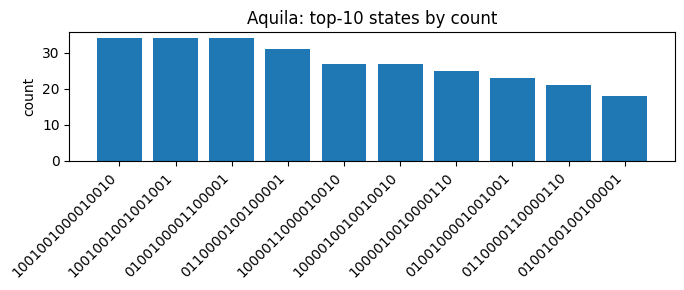

In [2]:
try:
    aquila_counts, aquila_total = aquila_parse(AQUILA_JSON, sorted=True, show_progress=True)
    print(f"Loaded Aquila JSON: {len(aquila_counts)} unique states, total shots = {aquila_total:.0f}")

    # show top 10 by count
    top10 = sorted(aquila_counts.items(), key=lambda kv: kv[1], reverse=True)[:10]
    df_top10 = pd.DataFrame(top10, columns=["state", "count"])
    display(df_top10)

    # quick bar plot (top 10)
    plt.figure(figsize=(7, 3))
    plt.bar(df_top10["state"], df_top10["count"])  # default colors
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("count")
    plt.title("Aquila: top-10 states by count")
    plt.tight_layout()
    plt.show()
except FileNotFoundError as e:
    print("Aquila JSON not found at:", AQUILA_JSON)
    print("Edit DATA_DIR if your path differs.")
    aquila_counts, aquila_total = {}, 0.0

## 3) Load Parquet <a id='parquet'></a>
Parquet files are read into a **probabilities dict** (bitstring → probability).

In [3]:
try:
    parq_probs = parse_parquet(PARQUET_FILE, show_progress=True)
    print(f"Loaded Parquet: {len(parq_probs)} states; total probability = {sum(parq_probs.values()):.6f}")
    # peek
    pd.DataFrame(list(parq_probs.items())[:10], columns=["state", "probability"])  # head
except FileNotFoundError as e:
    print("Parquet file not found at:", PARQUET_FILE)
    print("Edit DATA_DIR if your path differs.")
    parq_probs = {}

Starting: Parsing Parquet file...
Completed: Parsing Parquet file. Elapsed time: 0.46 seconds.                    ning:    0.00s
Loaded Parquet: 68 states; total probability = 10000000.000000


## 4) Load Plaintext <a id='text'></a>
Plaintext files are simple whitespace-delimited lines: `<state> <value>`.
The reader returns a **counts dict** and a **total count**.

In [4]:
try:
    txt_counts, txt_total = parse_file(TEXT_FILE, show_progress=True)
    print(f"Loaded TXT: {len(txt_counts)} unique states; total = {txt_total:.0f}")
    # peek
    pd.DataFrame(list(txt_counts.items())[:10], columns=["state", "count"])  # head
except FileNotFoundError as e:
    print("Text file not found at:", TEXT_FILE)
    print("Edit DATA_DIR if your path differs.")
    txt_counts, txt_total = {}, 0.0

Starting: Parsing file...
Completed: Parsing file. Elapsed time: 0.00 seconds.                            ng:    0.00s
Loaded TXT: 105 unique states; total = 1000000000


## 5) Normalize to probabilities <a id='normalize'></a>
Helpers to convert **counts → probabilities** and to produce a tidy `DataFrame`.

In [5]:
def counts_to_probabilities(counts: dict[str, float]) -> dict[str, float]:
    tot = float(sum(counts.values()))
    if tot <= 0.0:
        return {s: 0.0 for s in counts}
    return {s: float(v) / tot for s, v in counts.items()}

def dict_to_dataframe(d: dict[str, float], value_col: str) -> pd.DataFrame:
    return pd.DataFrame([(k, v) for k, v in d.items()], columns=["state", value_col])

# Build probability dicts when available
aquila_probs = counts_to_probabilities(aquila_counts) if aquila_counts else {}
txt_probs = counts_to_probabilities(txt_counts) if txt_counts else {}

print("Available distributions:")
print(" - Aquila probs:", len(aquila_probs))
print(" - Parquet probs:", len(parq_probs))
print(" - Text probs:", len(txt_probs))

Available distributions:
 - Aquila probs: 313
 - Parquet probs: 68
 - Text probs: 105


## 6) Compare distributions (optional) <a id='compare'></a>
If you loaded more than one distribution, you can align them and compare. Below we join on the **union of states** and compute an $L^1$ difference as a quick check.

In [6]:
def l1_distance(p: dict[str, float], q: dict[str, float]) -> float:
    keys = set(p) | set(q)
    return sum(abs(p.get(k, 0.0) - q.get(k, 0.0)) for k in keys)

if aquila_probs and parq_probs:
    print("L1(Aquila, Parquet) =", l1_distance(aquila_probs, parq_probs))
if txt_probs and parq_probs:
    print("L1(Text, Parquet)   =", l1_distance(txt_probs, parq_probs))
if aquila_probs and txt_probs:
    print("L1(Aquila, Text)    =", l1_distance(aquila_probs, txt_probs))

L1(Aquila, Parquet) = 10000000.999999957
L1(Text, Parquet)   = 9999999.00000041
L1(Aquila, Text)    = 2.0000000000000084


## 7) Save examples (commented) <a id='save'></a>
Here are examples for saving. They're **commented out** so running the notebook won't write files by default.
Uncomment to save to Parquet or plaintext.


In [7]:
# --- Save probabilities to Parquet ---
# OUT_PARQUET = "./aquila_probs.parquet"
# if aquila_probs:
#     save_dict_to_parquet(aquila_probs, OUT_PARQUET)

# --- Save counts to text ---
# OUT_TEXT = "./aquila_counts.txt"
# if aquila_counts:
#     save_data(aquila_counts, OUT_TEXT)

print("Save examples are commented out — uncomment to write files.")

Save examples are commented out — uncomment to write files.


---
**Notes**
- Aquila loader inverts `postSequence` bits to follow QCOM's convention (1 = excitation).
- The `sorted=True` option filters out shots with incomplete `preSequence`. Set `sorted=False` to keep all.
- Parquet I/O relies on `pyarrow` under the hood via pandas.
- Plaintext is handy for quick inspection and version diffs.
